In [16]:
import config
from cnn_builder import *
from config import *
from dataset_functions import *
import gc
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import papers
import paths
import rendering
import training_history

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
inf = 2e32
sampling_strategy = 'not minority'

network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

read_json_config(paths.config_file, network_type=network_type)

In [3]:
config.batch_size = 256 # Indian pines

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:47:44 2011', '__version__': '1.0', '__globals__': [], 'indian_pines_corrected': array([[[3172, 4142, 4506, ..., 1057, 1020, 1020],
        [2580, 4266, 4502, ..., 1064, 1029, 1020],
        [3687, 4266, 4421, ..., 1061, 1030, 1016],
        ...,
        [2570, 3890, 4320, ..., 1042, 1021, 1015],
        [3170, 4130, 4320, ..., 1054, 1024, 1020],
        [3172, 3890, 4316, ..., 1043, 1034, 1016]],

       [[2576, 4388, 4334, ..., 1047, 1030, 1006],
        [2747, 4264, 4592, ..., 1055, 1039, 1015],
        [2750, 4268, 4423, ..., 1047, 1026, 1015],
        ...,
        [3859, 4512, 4605, ..., 1056, 1035, 1015],
        [3686, 4264, 4690, ..., 1051, 1012, 1020],
        [2744, 4268, 4597, ..., 1047, 1019, 1016]],

       [[2744, 4146, 4416, ..., 1055, 1029, 1025],
        [2576, 4389, 4416, ..., 1051, 1021, 1011],
        [2744, 4273, 4420, ..., 1068, 1033, 1010],
        ...,
        [2570, 4266, 4509, ..

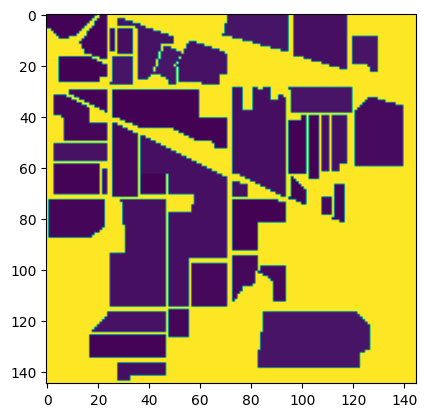

Class 0: 46
Class 1: 1428
Class 2: 830
Class 3: 237
Class 4: 483
Class 5: 730
Class 6: 28
Class 7: 478
Class 8: 20
Class 9: 972
Class 10: 2455
Class 11: 593
Class 12: 205
Class 13: 1265
Class 14: 386
Class 15: 93
Class 16: 10776
Min: 955.0, Max: 9604.0, Size: (145, 145, 200)


In [5]:
hc_set = HypercubeSet(hc_array=[load_indian_pines_umat(plot_hc=False, plot_mask=True)])
hc_set.print_metadata()

In [6]:
ground_label = hc_set.get_most_frequent_label()
print(ground_label)

16


In [7]:
hc_set.obtain_ground_labels(ground_label=ground_label)
hc_set.obtain_train_indices(test_percentage=config.test_split, patch_size=config.patch_size, patch_overlapping=config.patch_overlapping)

In [8]:
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

(21025, 200)
(21025,)
on 0: (14717, 200)                                                                                                      
|████████████████████████████████████████| 2/2 [100%] in 1.8s (1.14/s)                                                  


In [9]:
num_classes = hc_set.get_num_classes() - 1
img_shape = (config.patch_size, config.patch_size, config.num_target_features)

In [10]:
X_test, y_test = hc_set.split_test(patch_size=config.patch_size)
y_test = reduce_labels_center(y_test)
X_test, y_test = remove_labels(X_test, y_test, [ground_label])
(X_test, y_test), _, _ = balance_classes(X_test, y_test, reduce=True, clustering=False, strategy=sampling_strategy)

|████████████████████████████████████████| 6308/6308 [100%] in 0.0s (261764.45/s)                                       


In [33]:
network_name = get_name(network_type)
network_file = os.path.join(paths.result_folder + 'network/', network_name + "_0.h5")
model = keras.models.load_model(network_file,
                            custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                            'SecondOrderPooling': papers.aspn.SecondOrderPooling})
model.trainable = True
non_trainable_layers = [2, 3, 6, 7, 9, 10, 11, 16, 17, 18]
network_name = network_name + '_indian_pines'

x = Dense(num_classes)(model.layers[-2].output)
model = Model(inputs=model.input, outputs=x)
compile_network(model, network_type, network_name, num_classes, show_summary=True, render_image=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23, 23, 30)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape (Reshape)              (None, 529, 30)      0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 529, 30)      0           ['reshape[0][0]']                
                                                                                                  
 spatial_attention (SpatialAtte  (None, 529, 30)     1058        ['lambda[0][0]']           

In [34]:
history = training_history.TrainingHistory(accuracy_name='sparse_categorical_accuracy')
callbacks, time_callback = get_callback_list(model_name=network_name, test_id=100)

In [35]:
max_samples = 100000
starting_index = 0

while True:
    X_train, y_train = hc_set.split_train(patch_size=config.patch_size, max_train_samples=max_samples,
                                          starting_index=starting_index, remove=False)

    if len(X_train) > 0:
        y_train = reduce_labels_center(y_train)
        X_train, y_train = remove_labels(X_train, y_train, [ground_label])
        #(patch, patch_label), _, _ = balance_classes(X_train, y_train, reduce=True, clustering=False, strategy=sampling_strategy)
        patch, patch_label = X_train, y_train

        # Remove patches with label 255
        # indices = np.where(patch_label != 255)
        # patch = patch[indices]
        # patch_label = patch_label[indices]

        #rendering.render_mask_histogram(patch_label)

        X_train_augment, y_train_augmented = augment_chunks(patch, patch_label)
        history.append_history(run_model(model, X_train_augment, y_train_augmented,
                                         validation_split=validation_split, callbacks=callbacks).history,
                               training_callback=time_callback, samples=X_train_augment)

        del X_train_augment, y_train_augmented
        del patch, patch_label
    else:
        break

    del X_train, y_train
    starting_index += max_samples

    gc.collect()

|████████████████████████████████████████| 14717/14717 [100%] in 0.1s (249072.88/s)                                     
Training for 100 epochs with batch size of 512...
Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 4.2975 - sparse_categorical_accuracy: 0.4968
Epoch 1: val_loss improved from inf to 2.11986, saving model to results/network\allopezr_2d_23x22_16_indian_pines_100.h5
52/52 [==============================] - 5s 64ms/step - loss: 4.2896 - sparse_categorical_accuracy: 0.4972 - val_loss: 2.1199 - val_sparse_categorical_accuracy: 0.6533
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 2.4654 - sparse_categorical_accuracy: 0.5622
Epoch 2: val_loss did not improve from 2.11986
52/52 [==============================] - 2s 48ms/step - loss: 2.4654 - sparse_categorical_accuracy: 0.5622 - val_loss: 2.3966 - val_sparse_categorical_accuracy: 0.6045
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 2.5729 - sparse_categorical_

In [14]:
test_prediction_prob = model.predict(X_test)
test_prediction = np.argmax(test_prediction_prob, axis=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

3/3 [==============================] - 0s 6ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9875
Test Loss: 0.010449012741446495, Test Accuracy: 0.987500011920929
